# Stability Demo

Optimal number of topics is supposed to make models more stable in some way.
For example, [renormalization](Renormalization-Demo.ipynb) is also about stability: entropy means uncertainty, so the lower the entropy, the more stable the model is and so the better is the corresponding number of topics.

Here goes a more intuitive way to estimate stability: train models on different data subsamples and compare them.
Optimal number of topics is supposed to let models trained on different documents of the same collection be alike.
There are a couple of technical questions though, such as:
* how big should training subsamples be
* how to estimate the distance between topic models/between topics of topic models

Another way to introduce some noise in the training process would be to change the order of documents in the collection.
However, the order of documents doesn't play any role in [BigARTM library](https://github.com/bigartm/bigartm).

In [ ]:
# General imports

import os
import tempfile

from matplotlib import pyplot as plt

%matplotlib inline

In [ ]:
# Making `topnum` module visible for Python

import sys

sys.path.insert(0, '..')

In [ ]:
# Optimal number of topics

from topicnet.dataset_manager import load_dataset

from topnum.data.vowpal_wabbit_text_collection import VowpalWabbitTextCollection
from topnum.search_methods import StabilitySearchMethod

## Data

Let's use PostNauka dataset available in [TopicNet library](https://github.com/machine-intelligence-laboratory/TopicNet).

In [ ]:
DATASET_NAME = 'postnauka'

In [ ]:
WORKING_FOLDER_PATH = tempfile.mkdtemp()

DATASET_INTERNALS_FOLDER_PATH = os.path.join(
    WORKING_FOLDER_PATH,
    f'{DATASET_NAME}__internals',
)

In [ ]:
DATASET = load_dataset(
    DATASET_NAME,
    internals_folder_path=DATASET_INTERNALS_FOLDER_PATH,
)

100%|██████████| 5.55M/5.55M [00:00<00:00, 64.9MiB/s]


In [ ]:
DATASET._data_path

'/data/topicnet/lib/python3.6/site-packages/topicnet/dataset_manager/postnauka.csv'

Checking if all OK with data, what modalities does the collection have.

In [ ]:
DATASET._data.head()

,id,vw_text,raw_text
id,,,
1.txt,1.txt,1.txt |@author fuchs preobrazhensky tabachniko...,@title Автограф # «Математический дивертисмент...
2.txt,2.txt,2.txt |@word книга:2 лекция:3 рассматриваться:...,@title Главы: Маскулинности в российском конте...
3.txt,3.txt,3.txt |@word развитие появляться пиджина:4 бел...,@title Пиджины и креольские языки | @snippet Л...
4.txt,4.txt,4.txt |@word стандартный задача:3 состоять:4 р...,@title FAQ: Физиология микроводорослей | @snip...
5.txt,5.txt,5.txt |@2gramm повседневный_практика государст...,@title Русская государственная идеология | @sn...


In [ ]:
DATASET._extract_possible_modalities()

{'@2gramm', '@3gramm', '@author', '@post_tag', '@snippet', '@title', '@word'}

Creating batches

In [ ]:
DATASET.get_batch_vectorizer()

artm.BatchVectorizer(data_path="/tmp/tmpgjkfz3gp/postnauka__internals/batches", num_batches=4)

In [ ]:
os.listdir(DATASET_INTERNALS_FOLDER_PATH)

['batches', 'vw.txt']

Defining a text collection entity, which is to be passed to topic number search method later:

In [ ]:
text_collection = VowpalWabbitTextCollection.from_dataset(
    DATASET,
    main_modality='@word',
    modalities=['@word', '@title', '@snippet']
)

## Search

The searching method itself

In [ ]:
optimizer = StabilitySearchMethod(
    min_num_topics       = 1,
    max_num_topics       = 110,
    num_topics_interval  = 10,
    num_fit_iterations   = 20,    # 100 or 200 surely should be enough
                                  # 20 -- for demonstration purposes
    model_num_processors = 1,
    max_num_top_words    = 1000,  # for quicker topic comparison
)

Fulfilling the search:

In [ ]:
%%time

optimizer.search_for_optimum(
    text_collection,
    num_dataset_subsamples = 5,
    dataset_subsample_size = 0.5,
)

Folder "/tmp/stability_approach__z12famso" has no sub-datasets for training! Subsampling data...
100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

Training models for different numbers of topics...
100%|██████████| 11/11 [45:08<00:00, 246.24s/it]

Estimating stability for different numbers of topics...
  0%|          | 0/11 [00:00<?, ?it/s]
  0%|          | 0/10.0 [00:00<?, ?it/s]
 20%|██        | 2/10.0 [00:00<00:00, 16.90it/s]
 40%|████      | 4/10.0 [00:00<00:00, 16.84it/s]
 60%|██████    | 6/10.0 [00:00<00:00, 17.05it/s]
 80%|████████  | 8/10.0 [00:00<00:00, 17.06it/s]
100%|██████████| 10/10.0 [00:00<00:00, 17.05it/s]
  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]
  0%|          | 0/10.0 [00:00<?, ?it/s]
 10%|█         | 1/10.0 [00:00<00:02,  3.55it/s]
 20%|██        | 2/10.0 [00:00<00:02,  3.53it/s]
 30%|███       | 3/10.0 [00:00<00:01,  3.56it/s]
 40%|████      | 4/10.0 [00:01<00:01,  3.55it/s]
 50%|█████     | 5/10.0 [00:01<00:01,  3.53it/s]
 60%|██████    | 6/10.0 [00:01<00:01,  3

The search method's result may be accessed as `optimizer._result`.
Let's see what is available here:

In [ ]:
list(optimizer._result.keys())

['stability_metrics_for_num_topics']

In [ ]:
optimizer._result

{'stability_metrics_for_num_topics': {1: {'std': 0.005155798268201555,
   'var': 2.6582255782390152e-05,
   'range': 0.01590726376794882,
   'interquartile_range': 0.006782197429255898},
  11: {'std': 0.17818067032136625,
   'var': 0.031748351276171406,
   'range': 0.5842870623628347,
   'interquartile_range': 0.15480202744923677},
  21: {'std': 0.24780425094957242,
   'var': 0.06140694678867867,
   'range': 0.7259058589366365,
   'interquartile_range': 0.38879631687902894},
  31: {'std': 0.30053310815845585,
   'var': 0.09032014909938213,
   'range': 1.1983873551797615,
   'interquartile_range': 0.10624699947623739},
  41: {'std': 0.3610415067685589,
   'var': 0.13035096960971135,
   'range': 1.0690906814473138,
   'interquartile_range': 0.5697156488286303},
  51: {'std': 0.49261286311222957,
   'var': 0.24266743290362822,
   'range': 1.2844582735160088,
   'interquartile_range': 0.6929622313247918},
  61: {'std': 0.5584869661154541,
   'var': 0.31190769132084445,
   'range': 1.787060

## A Bit of Analysis

Let's plot computed topic model stability metrics for different number of topics

In [ ]:
numbers_of_topics = list(list(optimizer._result.values())[0].keys())
num_topics_metrics = list(list(optimizer._result.values())[0].values())

In [ ]:
num_topics_metrics[0]

{'std': 0.005155798268201555,
 'var': 2.6582255782390152e-05,
 'range': 0.01590726376794882,
 'interquartile_range': 0.006782197429255898}

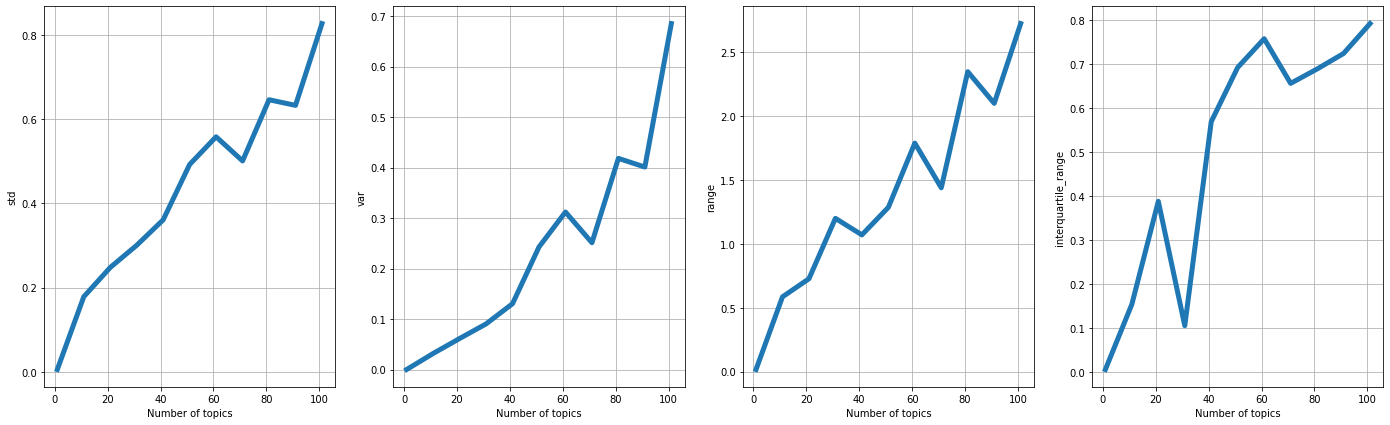

In [ ]:
fig, axes = plt.subplots(
    1, len(num_topics_metrics[0]),
    figsize=(6 * len(num_topics_metrics[0]), 7)
)


for stability_metric, ax in zip(num_topics_metrics[0], axes):
    ax.plot(
        numbers_of_topics,
        [v[stability_metric] for v in num_topics_metrics],
        lw=5
    )
    
    ax.grid(True)
    ax.set_ylabel(stability_metric)
    ax.set_xlabel('Number of topics')


plt.show()

IQR has a sharp minimum around $30$ topics.
And all four metrics has a local minimum around 70 topics.

## Appendix. Some Developer Notes

The main point is the following: setting `max_num_top_words` to some reasonable number (eg. `1000` or lower) helps to reduce the computation time significantly.

In [ ]:
import numpy as np
import pandas as pd
import tqdm

from lapsolver import solve_dense

In [ ]:
optimizer._models_folder_path

'/tmp/tmp_8oo6ahe'

In [ ]:
! ls '/tmp/tmp_8oo6ahe/num_topics_080'

model_0  model_1  model_2  model_3  model_4


In [ ]:
phi_a = pd.read_csv(
    '/tmp/tmp_8oo6ahe/num_topics_100/model_0/phi.csv',
    index_col=0,
)

phi_b = pd.read_csv(
    '/tmp/tmp_8oo6ahe/num_topics_100/model_1/phi.csv',
    index_col=0,
)

We have ~$30\,000$ words in each topic.

In [ ]:
phi_a.shape, phi_b.shape

((31258, 100), (31455, 100))

Let's first try not to use `max_num_top_words` by setting it equal `None`.

In [ ]:
optimizer._max_num_top_words = None # 1000

P.S.
In the cell below is code copy-pasted from .py files.
We collect topics from models to compare them further.
And `max_num_top_words` is either reducing the number of words for each topic, or doing nothing.

In [ ]:
assert phi_a.shape[1] == phi_b.shape[1]

num_topics = phi_a.shape[1]
topic_distances = np.zeros(shape=(num_topics, num_topics))
topic_indices = list(range(num_topics))


print('Creating lists')


if optimizer._max_num_top_words is None:
    topics_a = [
        phi_a.iloc[:, phi_col] for phi_col in topic_indices
    ]
    topics_b = [
        phi_b.iloc[:, phi_col] for phi_col in topic_indices
    ]
else:
    topics_a = [
        phi_a.iloc[:, phi_col].sort_values(ascending=False)[:optimizer._max_num_top_words]
        for phi_col in topic_indices
    ]
    topics_b = [
        phi_b.iloc[:, phi_col].sort_values(ascending=False)[:optimizer._max_num_top_words]
        for phi_col in topic_indices
    ]

Creating lists


Checking if all topics collected

In [ ]:
len(topics_b)

100

In [ ]:
optimizer._max_num_top_words

And here is the core part: computation of pairwise topic distances

In [ ]:
print('Computing distance')

for topic_index_a, topic_a in tqdm.tqdm(enumerate(topics_a), total=len(topics_a)):
    for topic_index_b, topic_b in enumerate(topics_b):
        topic_distance = optimizer._compute_topic_distance(
            topic_a, topic_b
        )
        topic_distances[topic_index_a, topic_index_b] = topic_distance

  0%|          | 0/100 [00:00<?, ?it/s]

Computing distance


100%|██████████| 100/100 [03:44<00:00,  2.24s/it]


Too slow.

And let's count the time needed for the computation of one distance

In [ ]:
%%timeit
optimizer._compute_topic_distance(
    topic_a, topic_b
)

23 ms ± 24.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


And what would be if we have set `max_num_top_words = 1000`:

In [ ]:
%%timeit

optimizer._compute_topic_distance(
    topic_a, topic_b
)

960 µs ± 1.96 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


$960$ µs (None) vs $23\,000$ µs ($1000$)!

Let's look at some distances

In [ ]:
topic_distances[0]

array([0.62114394, 0.90923059, 0.9087452 , 0.9123719 , 0.91654612,
       0.90235641, 0.91053944, 0.91119898, 0.89946246, 0.92095889,
       0.92320303, 0.89471967, 0.91476485, 0.93568774, 0.9209186 ,
       0.93453273, 0.91282153, 0.9129249 , 0.90786277, 0.88436017,
       0.91365809, 0.90866124, 0.8931335 , 0.91332144, 0.90382684,
       0.88744653, 0.90952673, 0.92215811, 0.89026398, 0.90182428,
       0.92402517, 0.91287951, 0.89235544, 0.90899086, 0.91628247,
       0.89179321, 0.91119629, 0.88453934, 0.88741315, 0.90133225,
       0.9030886 , 0.92540002, 0.9341681 , 0.89798052, 0.91682521,
       0.90480055, 0.93206356, 0.91658295, 0.89240712, 0.89223456,
       0.88348358, 0.92645066, 0.91902837, 0.91534864, 0.90509359,
       0.89102454, 0.91031308, 0.90458832, 0.91796801, 0.91371667,
       0.90714265, 0.91382986, 0.90292646, 0.89310802, 0.90597783,
       0.86471209, 0.9087681 , 0.92076784, 0.90450044, 0.91778618,
       0.92809178, 0.91388617, 0.91474045, 0.89104176, 0.90578

Realization of Hungarian method used here is actually very quick (no `%%timeit` is needed, really)

In [ ]:
row_ids, column_ids = solve_dense(topic_distances)

float(np.sum(
    topic_distances[row_ids, column_ids]
))

75.0208838525727